In [17]:
import numpy as np
from scipy.sparse import csr_matrix,triu
import scipy.sparse as sparse
import pandas as pd
from linkpred.LinkPredictionDataset import LinkPredictionDataset
import networkx as nx
from scipy import linalg
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_fscore_support
import os
import os.path
import csv
import time
import matplotlib.pyplot as plt

In [2]:
edges_file = {}
for file in os.listdir("../data/derived/networks/preprocessed"):
    with open(f"../data/derived/networks/preprocessed/{file}/edge_table.csv") as f:
        reader = csv.reader(f)
        edges_file[file] = len(list(reader))

In [4]:
edges_file = {k: v for k, v in sorted(edges_file.items(), key=lambda item: item[1])}
print(len(edges_file))
edges_file_0_50k = {k:v for k,v in edges_file.items() if v <=50000}
print(len(edges_file_0_50k))
edges_file_50k_100k = {k:v for k,v in edges_file.items() if v>50000 and v <=100000}
print(len(edges_file_50k_100k))
edges_file_100k_150k = {k:v for k,v in edges_file.items() if v>100000 and v <=150000}
print(len(edges_file_100k_150k))
edges_file_150k_200k = {k:v for k,v in edges_file.items() if v>150000 and v <=200000}
print(len(edges_file_150k_200k))
edges_file_200k_250k = {k:v for k,v in edges_file.items() if v>200000 and v <=250000}
print(len(edges_file_200k_250k))
edges_file_250k_300k = {k:v for k,v in edges_file.items() if v>250000 and v <=300000}
print(len(edges_file_250k_300k))
edges_file_300k_350k = {k:v for k,v in edges_file.items() if v>300000 and v <=350000}
print(len(edges_file_300k_350k))

90
41
19
10
10
5
5
0


In [5]:
print(edges_file_0_50k.keys())

dict_keys(['polbooks', 'football', 'netscience', 'highschool', 'foodweb-baywet', 'foodweb-baydry', 'celegans', 'maayan-foodweb', 'jazz', 'sociopatterns-infectious', 'airport-rach', 'radoslaw-email-email', 'email', 'YeastS', 'japanesebookinter-st', 'moreno-health', 'petster', 'ca-GrQc', 'hep-th', 'opsahl-ucsocial', 'bitcoinalpha', 'opsahl-openflights', 'Caltech36', 'polblogs-rachith', 'ht09-contact-list', 'Reed98', 'p2p-Gnutella08', 'bitcoinotc', 'frenchbookinter-st', 'PGPgiantcompo', 'ca-HepTh', 'p2p-Gnutella09', 'p2p-Gnutella06', 'p2p-Gnutella05', 'Simmons81', 'p2p-Gnutella04', 'spanishbookinter-st', 'darwinbookinter-st', 'cond-mat', 'as-22july06', 'dblp-cite'])


In [3]:
def adj_to_nodes_edges(A):
    
    """ 
    This function change adjacency matrix to list of nodes and edges.
    Input and Parameters:
    -------
    A: the adjacency matrix
    Returns:
    -------
    nodes: node list of the given network
    edges: edge list of the given network
    Examples:
    -------
    >>> nodes, edges = adj_to_nodes_edges(A)
    """
    
    num_nodes = A.shape[0]
    nodes = range(num_nodes)
    edges = np.where(np.triu(A,1))
    row = edges[0]
    col = edges[1]
    edges = np.vstack((row,col)).T
    return nodes, edges

def gen_topol_feats(A_orig, A, edge_s): 
    times = {}
    """ 
    This function generates the topological features for matrix A (A_tr or A_ho) over edge samples edge_s (edge_tr or edge_ho).
    Input and Parameters:
    -------
    A: the training or holdout adjacency matrix that the topological features are going to be computed over
    A_orig: the original adjacency matrix
    edge_s: the sample set of training or holdout edges that the topological features are going to be computed over
    Returns:
    -------
    df_feat: data frame of features
    Examples:
    -------
    >>> gen_topol_feats(A_orig, A_tr, edge_tr)
    >>> gen_topol_feats(A_orig, A_ho, edge_ho)
    """

    _ , edges = adj_to_nodes_edges(A)    
    nodes = [int(iii) for iii in range(A.shape[0])]
    N = len(nodes)
    if len(edges.shape)==1:
        edges = [(int(iii),int(jjj)) for iii,jjj in [edges]]
    else:
        edges = [(int(iii),int(jjj)) for iii,jjj in edges]

    # define graph
    G=nx.Graph()
    G.add_nodes_from(nodes)
    G.add_edges_from(edges)

    # average degree (AD)
    ave_deg_net = np.sum(A)/A.shape[0]
    # variance of degree distribution (VD)
    var_deg_net = np.sqrt(np.sum(np.square(np.sum(A,axis = 0)-ave_deg_net))/(A.shape[0]-1))
    start = time.time()
    # average (local) clustering coefficient (ACC)
    ave_clust_net = nx.average_clustering(G)
    stop = time.time()
    print("average_clustering", stop-start)
    times["average_clustering"] = stop-start
    
    # samples chosen - features
    edge_pairs_f_i = edge_s[:,0]
    edge_pairs_f_j = edge_s[:,1]
    
    start = time.time()
    # local number of triangles for i and j (LNT_i, LNT_j)  
    numtriang_nodes_obj = nx.triangles(G)
    numtriang_nodes = []
    for nn in range(len(nodes)):
        numtriang_nodes.append(numtriang_nodes_obj[nn])
     
    numtriang1_edges = []
    numtriang2_edges = []
    for ee in range(len(edge_s)):
        numtriang1_edges.append(numtriang_nodes[edge_s[ee][0]])
        numtriang2_edges.append(numtriang_nodes[edge_s[ee][1]])
        stop = time.time()
    print("triangles", stop-start)
    times["trianges"] = stop-start

    start = time.time()    
    # Page rank values for i and j (PR_i, PR_j)
    page_rank_nodes_obj = nx.pagerank(G)
    page_rank_nodes = []
    for nn in range(len(nodes)):
        page_rank_nodes.append(page_rank_nodes_obj[nn])
        
    page_rank1_edges = []
    page_rank2_edges = []
    for ee in range(len(edge_s)):
        page_rank1_edges.append(page_rank_nodes[edge_s[ee][0]])
        page_rank2_edges.append(page_rank_nodes[edge_s[ee][1]])
    stop = time.time()
    print("pgr", stop-start)
    times["page_rank"] = stop-start   

    start = time.time() 
    # j-th entry of the personalized page rank of node i (PPR)
    page_rank_pers_nodes = []
    hot_vec = {}
    for nn in range(len(nodes)):
        hot_vec[nn] = 0
    for nn in range(len(nodes)):
        hot_vec_copy = hot_vec.copy()
        hot_vec_copy[nn] = 1 
        page_rank_pers_nodes.append(nx.pagerank(G,personalization=hot_vec_copy))

    page_rank_pers_edges = []
    for ee in range(len(edge_s)):
        page_rank_pers_edges.append(page_rank_pers_nodes[edge_s[ee][0]][edge_s[ee][1]])
    stop = time.time()
    print("ppgr", stop-start) 
    times["personalised_page_rank"] = stop-start

    start = time.time()
    # local clustering coefficients for i and j (LCC_i, LCC_j)
    clust_nodes_obj = nx.clustering(G)
    clust_nodes = []
    for nn in range(len(nodes)):
        clust_nodes.append(clust_nodes_obj[nn])
    
    clust1_edges = []
    clust2_edges = []
    for ee in range(len(edge_s)):
        clust1_edges.append(clust_nodes[edge_s[ee][0]])
        clust2_edges.append(clust_nodes[edge_s[ee][1]])
    stop = time.time()
    print("clustering", stop-start) 
    times["local_clustering"] = stop-start

    start = time.time()
    # average neighbor degrees for i and j (AND_i, AND_j)
    ave_neigh_deg_nodes_obj = nx.average_neighbor_degree(G)
    ave_neigh_deg_nodes = []
    for nn in range(len(nodes)):
        ave_neigh_deg_nodes.append(ave_neigh_deg_nodes_obj[nn])
    
    ave_neigh_deg1_edges = []
    ave_neigh_deg2_edges = []
    for ee in range(len(edge_s)):
        ave_neigh_deg1_edges.append(ave_neigh_deg_nodes[edge_s[ee][0]])
        ave_neigh_deg2_edges.append(ave_neigh_deg_nodes[edge_s[ee][1]])
    stop = time.time()
    print("average_neighbor_degree", stop-start) 
    times["average_neighbor_degree"] = stop-start

    start = time.time()
    # degree centralities for i and j (DC_i, DC_j)
    deg_cent_nodes_obj = nx.degree_centrality(G)
    deg_cent_nodes = []
    for nn in range(len(nodes)):
        deg_cent_nodes.append(deg_cent_nodes_obj[nn])
     
    deg_cent1_edges = []
    deg_cent2_edges = []
    for ee in range(len(edge_s)):
        deg_cent1_edges.append(deg_cent_nodes[edge_s[ee][0]])
        deg_cent2_edges.append(deg_cent_nodes[edge_s[ee][1]])
    stop = time.time()
    print("degree centrality", stop-start)
    times["degree_centrality"] = stop-start

    start = time.time()
	# eigenvector centralities for i and j (EC_i, EC_j)
    tr = 1
    toler = 1e-6
    while tr == 1:
        try:
            eig_cent_nodes_obj = nx.eigenvector_centrality(G,tol = toler)
            tr = 0
        except:
            toler = toler*1e1
    
    eig_cent_nodes = []
    for nn in range(len(nodes)):
        eig_cent_nodes.append(eig_cent_nodes_obj[nn])
     
    eig_cent1_edges = []
    eig_cent2_edges = []
    for ee in range(len(edge_s)):
        eig_cent1_edges.append(eig_cent_nodes[edge_s[ee][0]])
        eig_cent2_edges.append(eig_cent_nodes[edge_s[ee][1]])
    stop = time.time()
    print("eigen vector centrality", stop-start) 
    times["eigenvector_centrality"] = stop-start

    start = time.time()
    # Katz centralities for i and j (KC_i, KC_j)
    ktz_cent_nodes_obj = nx.katz_centrality_numpy(G)
    ktz_cent_nodes = []
    for nn in range(len(nodes)):
        ktz_cent_nodes.append(ktz_cent_nodes_obj[nn])
    
    ktz_cent1_edges = []
    ktz_cent2_edges = []
    for ee in range(len(edge_s)):
        ktz_cent1_edges.append(ktz_cent_nodes[edge_s[ee][0]])
        ktz_cent2_edges.append(ktz_cent_nodes[edge_s[ee][1]])
    stop = time.time()
    print("katz centrality", stop-start)
    times["katz_centrality_numpy"] = stop-start 

    start = time.time()
    # Jaccard’s coefficient of neighbor sets of i, j (JC)
    jacc_coeff_obj = nx.jaccard_coefficient(G,edge_s)
    jacc_coeff_edges = []
    for uu,vv,jj in jacc_coeff_obj:
        jacc_coeff_edges.append([uu,vv,jj])   
    df_jacc_coeff = pd.DataFrame(jacc_coeff_edges, columns=['i','j','jacc_coeff'])
    df_jacc_coeff['ind'] = df_jacc_coeff.index
    stop = time.time()
    print("jaccard coeff", stop-start)

    start = time.time()
    # resource allocation index of i, j (RA)
    res_alloc_ind_obj = nx.resource_allocation_index(G, edge_s)
    res_alloc_ind_edges = []
    for uu,vv,jj in res_alloc_ind_obj:
        res_alloc_ind_edges.append([uu,vv,jj])
    df_res_alloc_ind = pd.DataFrame(res_alloc_ind_edges, columns=['i','j','res_alloc_ind'])    
    df_res_alloc_ind['ind'] = df_res_alloc_ind.index
    stop = time.time()
    print("resource alloc", stop-start)

    start = time.time()
  	# Adamic/Adar index of i, j (AA)
    adam_adar_obj =  nx.adamic_adar_index(G, edge_s)
    adam_adar_edges = []
    for uu,vv,jj in adam_adar_obj:
        adam_adar_edges.append([uu,vv,jj])
    df_adam_adar = pd.DataFrame(adam_adar_edges, columns=['i','j','adam_adar'])
    df_adam_adar['ind'] = df_adam_adar.index
    stop = time.time()
    print("adamic adar", stop-start)
    
    df_merge = pd.merge(df_jacc_coeff,df_res_alloc_ind, on=['ind','i','j'], sort=False)
    df_merge = pd.merge(df_merge,df_adam_adar, on=['ind','i','j'], sort=False)

    start = time.time()
    # preferential attachment (degree product) of i, j (PA)
    pref_attach_obj = nx.preferential_attachment(G, edge_s)
    pref_attach_edges = []
    for uu,vv,jj in pref_attach_obj:
        pref_attach_edges.append([uu,vv,jj])
    df_pref_attach = pd.DataFrame(pref_attach_edges, columns=['i','j','pref_attach'])
    df_pref_attach['ind'] = df_pref_attach.index
    stop = time.time()
    print("pa index", stop-start)
                
    # global features:
    # similarity of connections in the graph with respect to the node degree
    # degree assortativity (DA)

    start = time.time()
    deg_ass_net = nx.degree_assortativity_coefficient(G)
    stop = time.time()
    print("degree_assortativity_coefficient", stop-start)
    times["deg_ass"] = stop-start

    # transitivity: fraction of all possible triangles present in G
    # network transitivity (clustering coefficient) (NT)
    start = time.time()
    transit_net = nx.transitivity(G) 
    stop = time.time() 
    print("transitivity", stop-start)
    times["transitivity"] = stop-start
    # network diameter (ND)
    start = time.time()
    try:
        diam_net = nx.diameter(G)
    except:
        diam_net = np.inf
    stop = time.time()
    print("diameter", stop-start)
    times["diameter"] = stop-start

    start = time.time()    
    ave_deg_net = [ave_deg_net for ii in range(10000)]
    var_deg_net = [var_deg_net for ii in range(10000)]
    ave_clust_net = [ave_clust_net for ii in range(10000)]
    deg_ass_net = [deg_ass_net for ii in range(10000)]
    transit_net = [transit_net for ii in range(10000)]
    diam_net = [diam_net for ii in range(10000)]
    com_ne = []
    for ee in range(len(edge_s)):
        com_ne.append(len(sorted(nx.common_neighbors(G,edge_s[ee][0],edge_s[ee][1]))))
    stop = time.time()
    print("common neighbors", stop-start)

    start = time.time()
    # closeness centralities for i and j (CC_i, CC_j)
    closn_cent_nodes_obj = nx.closeness_centrality(G)
    closn_cent_nodes = []
    for nn in range(len(nodes)):
        closn_cent_nodes.append(closn_cent_nodes_obj[nn])

    closn_cent1_edges = []
    closn_cent2_edges = []
    for ee in range(len(edge_s)):
        closn_cent1_edges.append(closn_cent_nodes[edge_s[ee][0]])
        closn_cent2_edges.append(closn_cent_nodes[edge_s[ee][1]])
    stop = time.time()
    print("closeness centrality", stop-start)
    times["closeness_centrality"] = stop-start

    # shortest path between i, j (SP)
    start = time.time()        
    short_Mat_aux = nx.shortest_path_length(G)
    short_Mat={}
    for ss in range(N):
        value = next(short_Mat_aux)
        short_Mat[value[0]] = value[1]   
    short_path_edges = []
    for ee in range(len(edge_s)):
        if edge_s[ee][1] in short_Mat[edge_s[ee][0]].keys():
            short_path_edges.append(short_Mat[edge_s[ee][0]][edge_s[ee][1]])  
        else:
            short_path_edges.append(np.inf)
    stop = time.time()
    print("shortest path length", stop-start)
    times["shortest_path"] = stop-start

    start = time.time()  
    # load centralities for i and j (LC_i, LC_j)
    load_cent_nodes_obj = nx.load_centrality(G,normalized=True)
    load_cent_nodes = []
    for nn in range(len(nodes)):
        load_cent_nodes.append(load_cent_nodes_obj[nn])
    
    load_cent1_edges = []
    load_cent2_edges = []
    for ee in range(len(edge_s)):
        load_cent1_edges.append(load_cent_nodes[edge_s[ee][0]])
        load_cent2_edges.append(load_cent_nodes[edge_s[ee][1]])
    stop = time.time()
    print("load_centrality", stop-start)
    times["load_centrality"] = stop-start


    start = time.time()
    # shortest-path betweenness centralities for i and j (SPBC_i, SPBC_j)
    betw_cent_nodes_obj = nx.betweenness_centrality(G,normalized=True)
    betw_cent_nodes = []
    for nn in range(len(nodes)):
        betw_cent_nodes.append(betw_cent_nodes_obj[nn])
    
    betw_cent1_edges = []
    betw_cent2_edges = []
    for ee in range(len(edge_s)):
        betw_cent1_edges.append(betw_cent_nodes[edge_s[ee][0]])
        betw_cent2_edges.append(betw_cent_nodes[edge_s[ee][1]])
    stop = time.time()
    print("betweeness centrality", stop-start)
    times["betweenness_centrality"] = stop-start
      
    neigh_ = {}
    for nn in range(len(nodes)):
        neigh_[nn] = np.where(A[nn,:])[0]
    
    df_pref_attach = []
    start = time.time()
    for ee in range(len(edge_s)):
        df_pref_attach.append(len(neigh_[edge_s[ee][0]])*len(neigh_[edge_s[ee][1]]))
    stop = time.time()
    print("preferential_attachment", stop-start)
    times["preferential_attachment"] = stop-start
    
    start = time.time()
    U, sig, V = np.linalg.svd(A, full_matrices=False)
    S = np.diag(sig)
    Atilda = np.dot(U, np.dot(S, V))
    Atilda = np.array(Atilda)
    stop = time.time()

    f_mean = lambda x: np.mean(x) if len(x)>0 else 0
    # entry i, j in low rank approximation (LRA) via singular value decomposition (SVD)
    svd_edges = []
    # dot product of columns i and j in LRA via SVD for each pair of nodes i, j
    svd_edges_dot = []
    # average of entries i and j’s neighbors in low rank approximation
    svd_edges_mean = []
    for ee in range(len(edge_s)):
        svd_edges.append(Atilda[edge_s[ee][0],edge_s[ee][1]])
        svd_edges_dot.append(np.inner(Atilda[edge_s[ee][0],:],Atilda[:,edge_s[ee][1]]))
        svd_edges_mean.append(f_mean(Atilda[edge_s[ee][0],neigh_[edge_s[ee][1]]]))        
    stop = time.time()
    print("svd_edges_fullmatrices_false", stop-start)
    times["svd_edges_fullmatrices_false"] = stop-start

    # Leicht-Holme-Newman index of neighbor sets of i, j (LHN)
    start = time.time()
    f_LHN = lambda num,den: 0 if (num==0 and den==0) else float(num)/den 
    LHN_edges = [f_LHN(num,den) for num,den in zip(np.array(com_ne),np.array(df_pref_attach))]
    stop = time.time()
    print("LHN_edges", stop-start)
    times["LHN_edges"] = stop-start
    
    start = time.time()
    U, sig, V = np.linalg.svd(A)
    S = linalg.diagsvd(sig, A.shape[0], A.shape[1])
    S_trunc = S.copy()
    S_trunc[S_trunc < sig[int(np.ceil(np.sqrt(A.shape[0])))]] = 0
    Atilda = np.dot(np.dot(U, S_trunc), V)
    Atilda = np.array(Atilda)
    
    f_mean = lambda x: np.mean(x) if len(x)>0 else 0
    # an approximation of LRA (LRA-approx)
    svd_edges_approx = []
    # an approximation of dLRA (dLRA-approx)
    svd_edges_dot_approx = []
    # an approximation of mLRA (mLRA-approx)
    svd_edges_mean_approx = []
    for ee in range(len(edge_s)):
        svd_edges_approx.append(Atilda[edge_s[ee][0],edge_s[ee][1]])
        svd_edges_dot_approx.append(np.inner(Atilda[edge_s[ee][0],:],Atilda[:,edge_s[ee][1]]))
        svd_edges_mean_approx.append(f_mean(Atilda[edge_s[ee][0],neigh_[edge_s[ee][1]]])) 
    stop = time.time()
    print("svd_edges_approx", stop-start)
    times["svd_edges_approx"] = stop-start

    # number of nodes (N)
    num_nodes = A_orig.shape[0]
    # number of observed edges (OE)
    num_edges = int(np.sum(A)/2)
    
    # construct a dictionary of the features
    d = {'i':edge_pairs_f_i, 'j':edge_pairs_f_j, 'com_ne':com_ne, 'ave_deg_net':ave_deg_net, \
         'var_deg_net':var_deg_net, 'ave_clust_net':ave_clust_net, 'num_triangles_1':numtriang1_edges, 'num_triangles_2':numtriang2_edges, \
         'page_rank_pers_edges':page_rank_pers_edges, 'pag_rank1':page_rank1_edges, 'pag_rank2':page_rank2_edges, 'clust_coeff1':clust1_edges, 'clust_coeff2':clust2_edges, 'ave_neigh_deg1':ave_neigh_deg1_edges, 'ave_neigh_deg2':ave_neigh_deg2_edges,\
         'eig_cent1':eig_cent1_edges, 'eig_cent2':eig_cent2_edges, 'deg_cent1':deg_cent1_edges, 'deg_cent2':deg_cent2_edges, 'clos_cent1':closn_cent1_edges, 'clos_cent2':closn_cent2_edges, 'betw_cent1':betw_cent1_edges, 'betw_cent2':betw_cent2_edges, \
         'load_cent1':load_cent1_edges, 'load_cent2':load_cent2_edges, 'ktz_cent1':ktz_cent1_edges, 'ktz_cent2':ktz_cent2_edges, 'pref_attach':df_pref_attach, 'LHN':LHN_edges, 'svd_edges':svd_edges,'svd_edges_dot':svd_edges_dot,'svd_edges_mean':svd_edges_mean,\
         'svd_edges_approx':svd_edges_approx,'svd_edges_dot_approx':svd_edges_dot_approx,'svd_edges_mean_approx':svd_edges_mean_approx, 'short_path':short_path_edges, 'deg_assort':deg_ass_net, 'transit_net':transit_net, 'diam_net':diam_net, \
         'num_nodes':num_nodes, 'num_edges':num_edges}     
    
    # construct a dataframe of the features
    df_feat = pd.DataFrame(data=d)
    df_feat['ind'] = df_feat.index
    df_feat = pd.merge(df_feat,df_merge, on=['ind','i','j'], sort=False)
    return df_feat,times

In [4]:
def creat_full_set(df_t,df_f):
    
    """ 
    This reads dataframes created for positive and negative class, join them with their associated label.
    Input and Parameters:
    -------
    df_t: datafram of features for true edges
    df_f: datafram of features for true non-edges
    Returns
    -------
    df_all: a data frames with columns of features and ground truth 
    Examples:
    -------
    df_all = creat_full_set(df_t,df_f)
    """

    df_t = df_t.drop_duplicates(subset=['i','j'], keep="first")
    df_f = df_f.drop_duplicates(subset=['i','j'], keep="first")

    df_t.insert(2, "TP", 1, True)
    df_f.insert(2, "TP", 0, True)
    
    df_all = [df_t, df_f]
    df_all = pd.concat(df_all)
    
    # data cleaning
    df_all.loc[df_all['short_path'] == np.inf,'short_path'] = 1000*max(df_all.loc[~(df_all['short_path'] == np.inf),'short_path'])
    df_all.loc[df_all['diam_net'] == np.inf,'diam_net'] = 1e6
     
    return df_all

def creat_numpy_files(dir_results, df_ho, df_tr):
    
    """ 
    This function reads dataframes created for positive and negative classes, join them with their associated label.
    Input and Parameters:
    -------
    df_tr: datafram of features/ground truth for positive and negative class for model selection
    df_ho: datafram of features/ground truth for positive and negative class for held out model performance
    Returns:
    -------
    save numpy files of X_train_i and y_train_i for 5 folds, also X_Eseen/X_Eunseen, y_Eseen/y_Eunseen in dir_results
    Example:
    -------
    creat_numpy_files(dir_results, df_ho, df_tr)
    """
    
    feature_set = ['com_ne', 'ave_deg_net', 'var_deg_net', 'ave_clust_net',
           'num_triangles_1', 'num_triangles_2', 'page_rank_pers_edges',
           'pag_rank1', 'pag_rank2', 'clust_coeff1', 'clust_coeff2',
           'ave_neigh_deg1', 'ave_neigh_deg2', 'eig_cent1', 'eig_cent2',
           'deg_cent1', 'deg_cent2', 'clos_cent1', 'clos_cent2', 'betw_cent1',
           'betw_cent2', 'load_cent1', 'load_cent2', 'ktz_cent1', 'ktz_cent2',
           'pref_attach', 'LHN', 'svd_edges', 'svd_edges_dot', 'svd_edges_mean',
           'svd_edges_approx', 'svd_edges_dot_approx', 'svd_edges_mean_approx',
           'short_path', 'deg_assort', 'transit_net', 'diam_net',
           'jacc_coeff', 'res_alloc_ind', 'adam_adar' , 'num_nodes','num_edges']  

    X_test_heldout = df_ho
    y_test_heldout = np.array(df_ho.TP)
    
    
    X_train_orig = df_tr
    y_train_orig = np.array(df_tr.TP)

    skf = StratifiedKFold(n_splits=5,shuffle=True)
    skf.get_n_splits(X_train_orig, y_train_orig)

    if not os.path.isdir(dir_results+'/'):
        os.mkdir(dir_results+'/')
        
    nFold = 1 
    for train_index, test_index in skf.split(X_train_orig, y_train_orig):

        cv_train = list(train_index)
        cv_test = list(test_index)
         
         
        train = X_train_orig.iloc[np.array(cv_train)]
        test = X_train_orig.iloc[np.array(cv_test)]

        y_train = train.TP
        y_test = test.TP
        

        X_train = train.loc[:,feature_set]
        X_test = test.loc[:,feature_set]

        X_test.fillna(X_test.mean(), inplace=True)
        X_train.fillna(X_train.mean(), inplace=True)

        sm = RandomOverSampler()
        X_train, y_train = sm.fit_resample(X_train, y_train)

        np.save(dir_results+'/X_trainE_'+'cv'+str(nFold), X_train)
        np.save(dir_results+'/y_trainE_'+'cv'+str(nFold), y_train)
        np.save(dir_results+'/X_testE_'+'cv'+str(nFold), X_test)
        np.save(dir_results+'/y_testE_'+'cv'+str(nFold), y_test)

        print( "created fold ",nFold, " ...")
        
        nFold = nFold + 1

    seen = X_train_orig
    y_seen = seen.TP
    X_seen = seen.loc[:,feature_set]
    X_seen.fillna(X_seen.mean(), inplace=True)  

    # balance train set with upsampling
    sm = RandomOverSampler()
    X_seen, y_seen = sm.fit_resample(X_seen, y_seen)

    np.save(dir_results+'/X_Eseen', X_seen)
    np.save(dir_results+'/y_Eseen', y_seen)
    print( "created train set ...")


    unseen = X_test_heldout
    y_unseen = unseen.TP
    X_unseen = unseen.loc[:,feature_set]
    X_unseen.fillna(X_unseen.mean(), inplace=True) 

    np.save(dir_results+'/X_Eunseen', X_unseen)
    np.save(dir_results+'/y_Eunseen', y_unseen) 
    print( "created holdout set ...")

def model_selection(path_to_data, path_to_results, n_depths, n_ests):
    
    """ 
    This function runs cross validation on train set and finds the random forest model parameters which yeilds to best fmeasure.
    Input and Parameters:
    -------
    path_to_data: path to held out featute matrices 
    path_to_results: path to save model performance ast txt file
    n_depth: a list of max_depths for random forest parameter
    n_est: a list of n_estimators for random forest parameter
    Returns:
    -------
    n_depth: n_depth which yeild to maximum fmeasure
    n_est: n_est which yeild to maximum fmeasure
    Examples:
    -------
    n_depth, ne_est = model_selection(path_to_data, path_to_results, n_depths, n_ests)
    """
    
    fmeasure_matrix = np.zeros((len(n_depths),len(n_ests)))
    
    if not os.path.isdir(path_to_results):
        os.mkdir(path_to_results)
    
    # load train and validation set for each fold
    X_train = {}
    y_train = {}
    X_test = {}
    y_test = {}
    for nFold in range(1,6):
        
        exec("X_train["+ str(nFold) +"] = np.load( path_to_data + '/X_trainE_cv"+ str(nFold) +".npy')")
        exec("y_train["+ str(nFold) +"] = np.load( path_to_data + '/y_trainE_cv"+ str(nFold) +".npy')")
        exec("X_test["+ str(nFold) +"] = np.load( path_to_data + '/X_testE_cv"+ str(nFold) +".npy')")
        exec("y_test["+ str(nFold) +"] = np.load( path_to_data + '/y_testE_cv"+ str(nFold) +".npy')")
    
    # run a grid search for parameter tuning 
    print("start grid search ... ")
    for n_ii, ii in enumerate(n_depths):
        for n_jj, jj in enumerate(n_ests):
        
            auc_measure = []     
            precision_total = np.zeros((5,2))
            recall_total = np.zeros((5,2))
            f_measure_total = np.zeros((5,2))
            
            for cv in range(1,6):
                
                 Xtr = X_train[cv]
                 ytr = y_train[cv]
                 Xts = X_test[cv]
                 yts = y_test[cv]
                
                 # train the model 
                 
                 dtree_model = RandomForestClassifier(max_depth=ii,n_estimators=jj).fit(Xtr, ytr)
                    
                 # predict for test test
                 dtree_predictions = dtree_model.predict(Xts)
                 dtree_proba = dtree_model.predict_proba(Xts)
                        
                 # calculate performance metrics
                 cm_dt4 = confusion_matrix(yts, dtree_predictions)
                 
                 auc_aux = roc_auc_score(yts, dtree_proba[:,1])
                 auc_measure.append(auc_aux)
                 
                 precision_aux, recall_aux, f_measure_aux, _ = precision_recall_fscore_support(yts, dtree_predictions, average=None)
                 precision_total[cv-1,:] = precision_aux
                 recall_total[cv-1,:] = recall_aux
                 f_measure_total[cv-1,:] = f_measure_aux
            # take average of performance metrics across folds
            mean_auc = np.mean(auc_measure)
            mean_precision = np.mean(precision_total,axis=0)
            mean_recall = np.mean(recall_total,axis=0)
            mean_f_measure = np.mean(f_measure_total,axis=0)
            
            # write the result in text file
            f = open( path_to_results + '/RF_Best_metrics.txt','w')
            f.write('mean_AUC = '+ str(mean_auc)+'\n')
            f.write('mean_precision = '+ str(mean_precision)+'\n')
            f.write('mean_recall = '+ str(mean_recall)+'\n')
            f.write('mean_f_measure = '+ str(mean_f_measure)+'\n')            
            f.close()
            
            # keep track of average fmeasure for each parameter set
            
            fmeasure_matrix[n_ii,n_jj] = mean_f_measure[0]
            
    # find the model parameters which gives the best average fmeasure on 5 fold validation sets    
    i,j = np.unravel_index(fmeasure_matrix.argmax(), fmeasure_matrix.shape)
    n_depth = n_depths[i]
    ne_est = n_ests[j]
    print("best parameters for random forest are: n_depth: "+str(n_depth)+", and n_estimators: "+str(ne_est))
    return n_depth, ne_est

In [5]:
def heldout_performance(path_to_data, path_to_results, n_depth, n_est):
    
    """ 
    This function trains a random forest model on seen data and performs prediction on heldout.
    Input and Parameters:
    -------
    path_to_data: path to held out featute matrices 
    path_to_results: path to save model performance ast txt file
    n_depth: max_depth for random forest parameter
    n_est: n_estimators for random forest parameter
    Returns:
    -------
    auc_measure: auc on heldout
    precision_total: precision of positive class on heldout
    recall_total: recall of positive class on heldout
    Examples:
    -------
    auc , precision, recall = heldout_performance(path_to_data, path_to_results, n_depth, n_est)
    """
    
    if not os.path.isdir(path_to_results):
        os.mkdir(path_to_results)
    f = open(path_to_results + '/RF_Best_metrics.txt','w')
    path_to_data = './feature_metrices'
    
    # read data
    X_train = np.load(path_to_data+'/X_Eseen.npy')
    y_train = np.load(path_to_data+'/y_Eseen.npy')
    X_test = np.load(path_to_data+'/X_Eunseen.npy')
    y_test = np.load(path_to_data+'/y_Eunseen.npy')
    
    
    col_mean = np.nanmean(X_train, axis=0)
    inds = np.where(np.isnan(X_train))
    X_train[inds] = np.take(col_mean, inds[1])
    
    col_mean = np.nanmean(X_test, axis=0)
    inds = np.where(np.isnan(X_test))
    X_test[inds] = np.take(col_mean, inds[1])
     
       
    # train the model
    dtree_model = RandomForestClassifier(n_estimators=n_est,max_depth=n_depth).fit(X_train, y_train)
    
    
    # feature importance and prediction on test set 
    feature_importance = dtree_model.feature_importances_
    dtree_predictions = dtree_model.predict(X_test)
    dtree_proba = dtree_model.predict_proba(X_test)
      
    # calculate performance metrics
    cm_dt4 = confusion_matrix(y_test, dtree_predictions)
    auc_measure = roc_auc_score(y_test, dtree_proba[:,1])
       
     
    precision_total, recall_total, f_measure_total, _ = precision_recall_fscore_support(y_test, dtree_predictions, average=None)
       
    
    
    f.write('heldout_AUC = '+ str(auc_measure)+'\n')
    f.write('heldout_precision = '+ str(precision_total)+'\n')
    f.write('heldout_recall = '+ str(recall_total)+'\n')
    f.write('heldout_f_measure = '+ str(f_measure_total)+'\n')
    f.write('feature_importance = '+ str(list(feature_importance))+'\n')
    f.close()
    
    print("AUC: " +str(np.round(auc_measure,2)))
    print("precision: " +str(np.round(precision_total[0],2)))
    print("recall: " +str(np.round(recall_total[0],2)))
    return auc_measure, precision_total[0], recall_total[0]

In [51]:
def lot_to_2dmatrix(lot):
    "list of tuples to 2D matrix"
    lot = np.array(lot)
    lot = lot.reshape(-1, len(lot[0]))

    return lot

def get_true_and_false_edges(Nsamples,true_candidates,false_candidates):
    edge_t = [] # list of true edges (positive samples)
    edge_f = [] # list of false edges (negative samples)
    for ll in range(Nsamples):
        edge_t_idx_aux = np.random.randint(len(true_candidates[0]))
        edge_f_idx_aux = np.random.randint(len(false_candidates[0]))
        edge_t.append((true_candidates[0][edge_t_idx_aux],true_candidates[1][edge_t_idx_aux]))
        edge_f.append((false_candidates[0][edge_f_idx_aux],false_candidates[1][edge_f_idx_aux]))
    
    return edge_t,edge_f


def topol_stacking(edge_table): 
    
    """ 
    This function extracts topological features and performs link prediction using stacking model on the input network (edges_orig).
    Input and Parameters:
    -------
    edges_orig: the original edge table
    Returns:
    -------
    Examples:
    -------
    >>> topol_stacking(edges_orig)
    """
    print("-"*60)
    src, trg = edge_table["src"].values, edge_table["trg"].values
    n_nodes = int(np.maximum(np.max(src), np.max(trg)) + 1)
    A_orig = csr_matrix((np.ones_like(src), (src, trg)), shape=(n_nodes, n_nodes))

    model_ho = LinkPredictionDataset(testEdgeFraction=0.5,negative_edge_sampler="degreeBiased")
    model_ho.fit(A_orig)
    A_ho, target_edge_table_ho = model_ho.transform()
    # print(len(x))

    model_tr = LinkPredictionDataset(testEdgeFraction=0.5,negative_edge_sampler="degreeBiased",)
    model_tr.fit(A_ho)
    A_tr, target_edge_table_tr = model_tr.transform()
    # print(len(y))

    A_orig = A_orig.todense()
    A_ho = A_ho.todense()
    A_tr = A_tr.todense()
    
    #### extract features #####

    A_diff = A_ho - A_tr
    e_diff = sparse.find(sparse.triu(A_diff,1)) # true candidates
    A_ho_aux = -1*A_ho + 1
    ne_ho = sparse.find(sparse.triu(A_ho_aux,1)) # false candidates
    Nsamples = 10000 # number of samples
    edge_t_tr,edge_f_tr = get_true_and_false_edges(Nsamples,e_diff,ne_ho)
    # reshape list of tuples to 2D matrix
    edge_t_tr = lot_to_2dmatrix(edge_t_tr)
    edge_f_tr = lot_to_2dmatrix(edge_f_tr)
    # get features
    df_f_tr = gen_topol_feats(A_orig, A_tr, edge_f_tr)
    df_t_tr = gen_topol_feats(A_orig, A_tr, edge_t_tr)
    
    A_diff = A_orig - A_ho
    e_diff = sparse.find(sparse.triu(A_diff,1)) # true candidates
    A_orig_aux = -1*A_orig + 1
    ne_orig = sparse.find(sparse.triu(A_orig_aux,1)) # false candidates
    Nsamples = 10000 # number of samples
    edge_t_ho,edge_f_ho = get_true_and_false_edges(Nsamples,e_diff,ne_orig)
    # reshape list of tuples to 2D matrix
    edge_t_ho = lot_to_2dmatrix(edge_t_ho)
    edge_f_ho = lot_to_2dmatrix(edge_f_ho)
    # get features
    df_f_ho = gen_topol_feats(A_orig, A_ho, edge_f_ho)
    df_t_ho = gen_topol_feats(A_orig, A_ho, edge_t_ho)
    
    #### load dataframes for train and holdout sets ####
    df_tr = creat_full_set(df_t_tr,df_f_tr)
    df_ho = creat_full_set(df_t_ho,df_f_ho)
    
    #### creat and save feature matrices #### 
    dir_output = './feature_metrices'  # output path
    creat_numpy_files(dir_output, df_ho, df_tr)
    
    #### perform model selection #### 
    path_to_data = './feature_metrices' 
    path_to_results = './results'
    n_depths = [3, 6] # here is a sample search space
    n_ests = [25, 50, 100] # here is a sample search space
    n_depth, n_est = model_selection(path_to_data, path_to_results, n_depths, n_ests)
    
    
    #### perform model selection #### 
    auc , precision, recall = heldout_performance(path_to_data, path_to_results, n_depth, n_est)

    return auc,precision,recall

In [28]:
edge_table = pd.read_csv("../data/derived/networks/preprocessed/darwinbookinter-st/edge_table.csv")

In [29]:
src, trg = edge_table["src"].values, edge_table["trg"].values
n_nodes = int(np.maximum(np.max(src), np.max(trg)) + 1)
A_orig = csr_matrix((np.ones_like(src), (src, trg)), shape=(n_nodes, n_nodes))

model_ho = LinkPredictionDataset(testEdgeFraction=0.5,negative_edge_sampler="degreeBiased")
model_ho.fit(A_orig)
A_ho, target_edge_table_ho = model_ho.transform()
# print(len(x))

model_tr = LinkPredictionDataset(testEdgeFraction=0.5,negative_edge_sampler="degreeBiased",)
model_tr.fit(A_ho)
A_tr, target_edge_table_tr = model_tr.transform()

100%|██████████| 11051/11051 [00:00<00:00, 451528.96it/s]


In [47]:
set(zip(A_ho.nonzero()[0],A_ho.nonzero()[1])).intersection(set(zip(edge_table.src.values,edge_table.src.values)))

pos = target_edge_table_ho[target_edge_table_ho.isPositiveEdge==1]
set(zip(pos.src.values,pos.trg.values)).intersection(set(zip(edge_table.src.values,edge_table.src.values)))

set()

In [12]:
topol_stacking(edge_table)

------------------------------------------------------------


100%|██████████| 11051/11051 [00:00<00:00, 393440.74it/s]


clustering 0.12096571922302246
triangles 0.10547018051147461
pgr 0.03634333610534668
ppgr 255.6991810798645
clustering 0.10332322120666504
average_neighbor_degree 0.020525693893432617
degree centrality 0.006956577301025391
eigen vector centrality 0.9506075382232666
katz centrality 4.203410863876343
jaccard coeff 0.31700921058654785
resource alloc 0.2622385025024414
adamic adar 0.2596418857574463
pa index 0.16411590576171875
degree_assortativity_coefficient 0.28833770751953125
diameter 39.10475277900696
common neighbors 0.1481797695159912
closeness centrality 37.54376721382141
shortest path length 37.709803342819214
load_centrality 167.07751846313477
betweeness centrality 207.6606261730194
svd 267.75518107414246
clustering 0.11911344528198242
triangles 0.0976400375366211
pgr 0.03324413299560547


KeyboardInterrupt: 

In [8]:
global_times = {}

In [18]:
edge_table = pd.read_csv("../data/derived/networks/preprocessed/p2p-Gnutella04/edge_table.csv")

In [12]:
src, trg = edge_table["src"].values, edge_table["trg"].values
n_nodes = int(np.maximum(np.max(src), np.max(trg)) + 1)
A_orig = csr_matrix((np.ones_like(src), (src, trg)), shape=(n_nodes, n_nodes))

model_ho = LinkPredictionDataset(testEdgeFraction=0.5,negative_edge_sampler="degreeBiased")
model_ho.fit(A_orig)
A_ho, target_edge_table_ho = model_ho.transform()
# print(len(x))

model_tr = LinkPredictionDataset(testEdgeFraction=0.5,negative_edge_sampler="degreeBiased",)
model_tr.fit(A_ho)
A_tr, target_edge_table_tr = model_tr.transform()
# print(len(y))

A_orig = A_orig.todense()
A_ho = A_ho.todense()
A_tr = A_tr.todense()

#### extract features #####

A_diff = A_ho - A_tr
e_diff = sparse.find(sparse.triu(A_diff,1)) # true candidates
A_ho_aux = -1*A_ho + 1
ne_ho = sparse.find(sparse.triu(A_ho_aux,1)) # false candidates
Nsamples = 10000 # number of samples
edge_t_tr,edge_f_tr = get_true_and_false_edges(Nsamples,e_diff,ne_ho)
# reshape list of tuples to 2D matrix
edge_t_tr = lot_to_2dmatrix(edge_t_tr)
edge_f_tr = lot_to_2dmatrix(edge_f_tr)
# get features
df_f_tr,times = gen_topol_feats(A_orig, A_tr, edge_f_tr)
global_times["p2p-Gnutella04"] = times

100%|██████████| 19997/19997 [00:00<00:00, 966752.31it/s]


Exception: Cannot remove edges by keeping the connectedness. Decrease the `fraction` parameter

In [11]:
pd.DataFrame(global_times)

,petster,jazz
average_clustering,0.013372,0.013293
trianges,0.018161,0.017850
page_rank,0.013355,0.012131
personalised_page_rank,12.036807,11.821886
local_clustering,0.017898,0.017239
average_neighbor_degree,0.007951,0.007331
degree_centrality,0.004876,0.004819
eigenvector_centrality,0.060350,0.057119
katz_centrality_numpy,1.022249,0.814307
deg_ass,0.012604,0.012024


In [35]:
df = pd.read_csv("times.csv")
df.rename(columns={"Unnamed: 0":"network"},inplace=True)

In [26]:
df = df.append(pd.DataFrame(global_times).T.reset_index().rename(columns={"index":"network"}))

/tmp/ipykernel_2508537/1752048716.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(global_times).T.reset_index().rename(columns={"index":"network"}))


In [28]:
df

,network,average_clustering,trianges,page_rank,personalised_page_rank,local_clustering,average_neighbor_degree,degree_centrality,eigenvector_centrality,katz_centrality_numpy,...,transitivity,diameter,closeness_centrality,shortest_path,load_centrality,betweenness_centrality,preferential_attachment,svd_edges_fullmatrices_false,LHN_edges,svd_edges_approx
0,polbooks,0.008651,0.008632,0.015643,0.519661,0.004909,0.004411,0.003946,0.010333,0.005595,...,0.000646,0.007486,0.011741,0.058984,0.018113,0.018921,0.027962,0.205920,0.015395,0.369959
1,darwinbookinter-st,0.025951,0.027341,0.030304,14.325124,0.019999,0.019189,0.004515,0.072772,1.260264,...,0.013539,2.170969,2.155640,2.545131,6.469111,7.562713,0.028860,20.478801,0.015182,5.812313
0,petster,0.013372,0.018161,0.013355,12.036807,0.017898,0.007951,0.004876,0.060350,1.022249,...,0.012583,2.096649,2.077280,2.100291,5.346169,6.602623,0.027341,10.929435,0.014907,11.539872
1,jazz,0.013293,0.017850,0.012131,11.821886,0.017239,0.007331,0.004819,0.057119,0.814307,...,0.092345,2.065917,2.098435,2.143224,5.305897,6.438191,0.027762,7.485000,0.015048,15.192256


In [31]:
df.to_csv("times.csv",index=False)

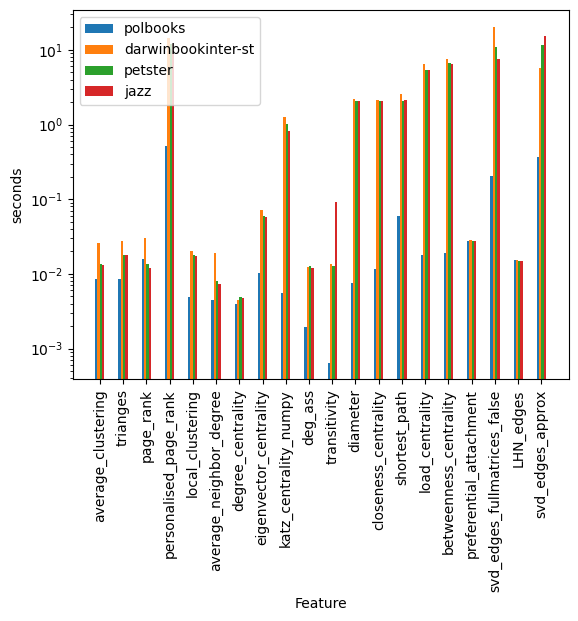

In [47]:
# Define the data
# data = {'network': ['polbooks', 'darwinbookinter-st', 'petster', 'jazz'],
#         'average_clustering': [0.008651, 0.025951, 0.013372, 0.013293],
#         'triangles': [0.008632, 0.027341, 0.018161, 0.01785],
#         'page_rank': [0.015643, 0.030304, 0.013355, 0.012131]}
data = df.to_dict(orient='list')

# Set the network column as the index
index = data.pop('network')

# Create a numpy array from the remaining data
values = np.array(list(data.values()))

# Set the width of each bar
bar_width = 0.1

# Set the x locations of the bars
x = np.arange(len(data.keys()))

# Create the figure and axes objects
fig, ax = plt.subplots()

# Plot each row as a separate bar
for i in range(len(index)):
    ax.bar(x + (i * bar_width), values[:, i], bar_width, label=index[i])

# Set the x-axis tick labels and tick locations
ax.set_xticks(x + ((len(index) - 1) / 2) * bar_width)
ax.set_xticklabels(data.keys(),rotation=90)

# Set the x-axis label
ax.set_xlabel('Feature')

# Set the y-axis label
ax.set_ylabel('seconds')
ax.set_yscale("log")

# Add a legend
ax.legend()

# Display the plot
plt.show()

In [94]:
import pickle as pkl
DIR = "../data/derived/optimal_stacking/feature-importance/"
d = {}
for data in os.listdir(DIR):
    with open(f"{DIR}/{data}/bestfeatures-rf_basedOn~optstack_negativeEdgeSampler~uniform_testEdgeFraction~0.2_sampleId~0.pkl","rb") as f:
        d[data] = pkl.load(f)

In [95]:
pd.DataFrame(d).head()

,polblogs-rachith,ca-GrQc,p2p-Gnutella04,opsahl-openflights,p2p-Gnutella09,opsahl-ucsocial,p2p-Gnutella08,spanishbookinter-st,ht09-contact-list,football,...,sociopatterns-infectious,YeastS,jazz,radoslaw-email-email,bitcoinotc,celegans,frenchbookinter-st,bitcoinalpha,hep-th,PGPgiantcompo
com_ne,0.071603,0.066737,0.000524,0.152647,0.000000,0.001136,0.000217,0.01805,0.000235,0.021386,...,0.147300,0.004137,0.059628,0.089633,0.022163,0.063153,0.000062,0.004214,0.047201,0.034334
ave_deg_net,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
var_deg_net,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ave_clust_net,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
num_triangles_1,0.007853,0.004969,0.000339,0.020646,0.000144,0.027022,0.000000,0.10558,0.002586,0.005013,...,0.010436,0.001095,0.003831,0.010141,0.058994,0.017550,0.053254,0.075372,0.000558,0.006867


Text(0.5, 1.0, 'Unifrom sampling')

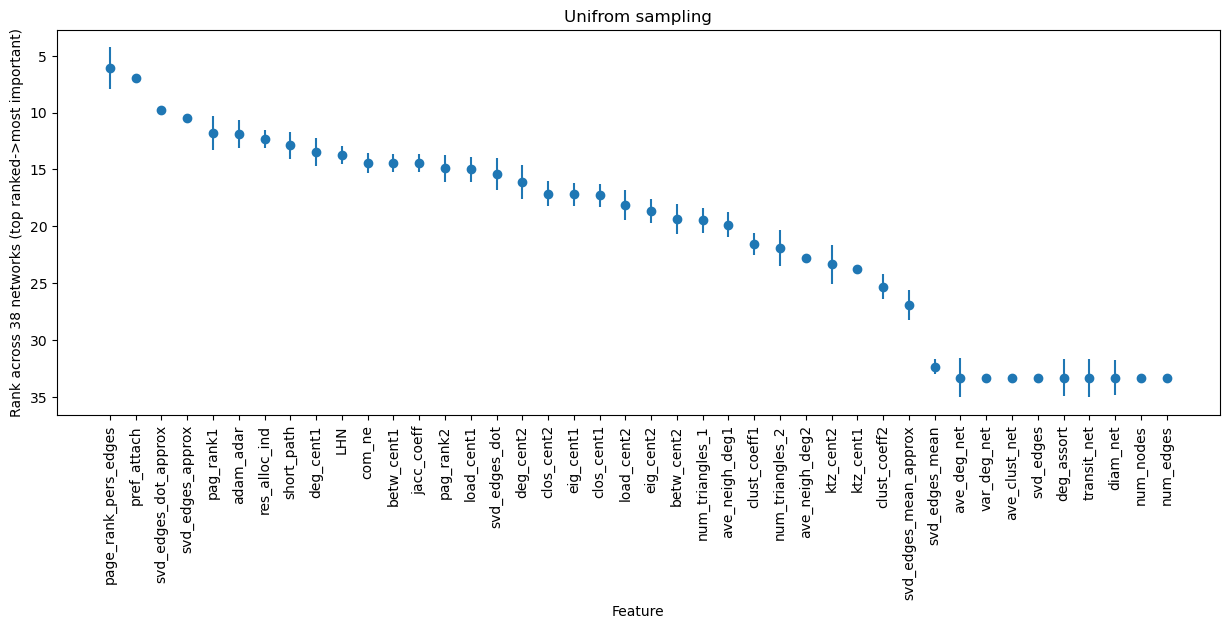

In [97]:
plt.figure(figsize=(15,5))
average_ranking = dict(pd.DataFrame(d).rank(method='min',ascending=False).T.mean())
average_ranking_sorted = {k:v for k,v in sorted(average_ranking.items(),key=lambda x:x[1])}
standard_mean_error = dict(pd.DataFrame(d).rank(method='min',ascending=False).T.sem())
standard_mean_error_sorted = {k:standard_mean_error[k] for k in standard_mean_error.keys()}
plt.errorbar(average_ranking_sorted.keys(),average_ranking_sorted.values(),yerr=list(standard_mean_error_sorted.values()),fmt='o')
_ =plt.xticks(rotation=90)
plt.gca().invert_yaxis() 
plt.ylabel("Rank across 38 networks (top ranked->most important)") 
plt.xlabel("Feature") 
plt.title("Unifrom sampling")

Text(0.5, 0, 'Feature')

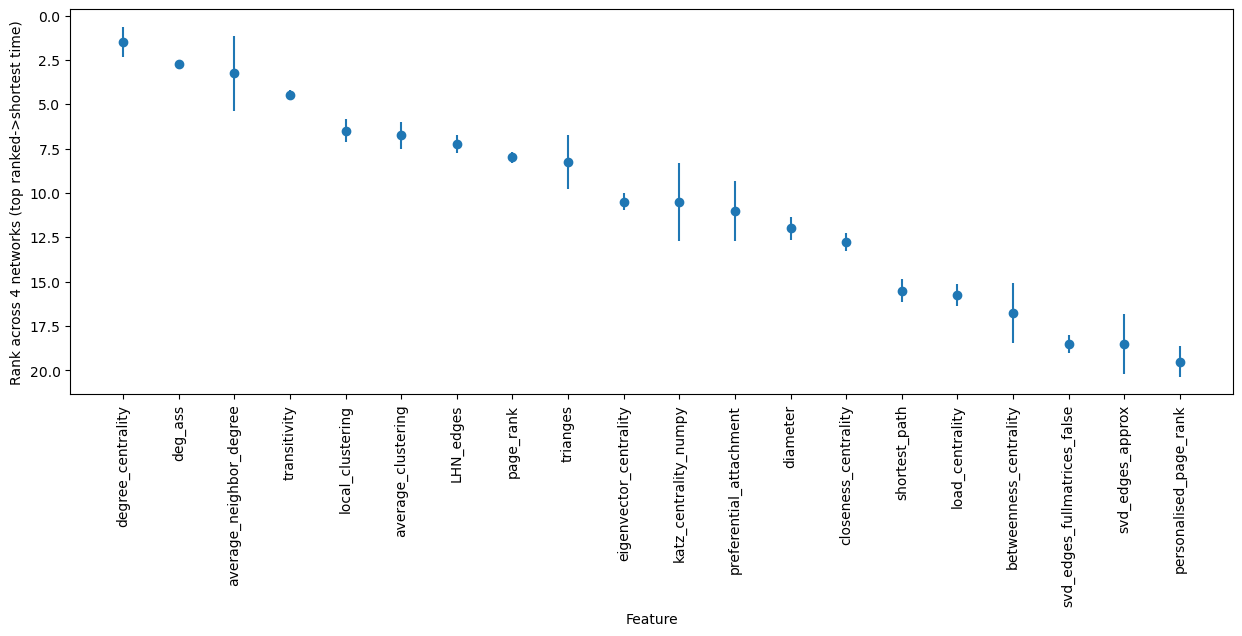

In [98]:
df = pd.read_csv("times.csv")
df.rename(columns={"Unnamed: 0":"network"},inplace=True)
df = df.set_index("network")

time_average_ranking = dict(df.T.rank(method='min',ascending=True).T.mean())
time_average_ranking = dict(df.T.rank(method='min',ascending=True).T.mean())
time_average_ranking_sorted = {k:v for k,v in sorted(time_average_ranking.items(),key=lambda x:x[1])}
time_standard_mean_error = dict(df.T.rank(method='min',ascending=True).T.sem())
time_standard_mean_error_sorted = {k:time_standard_mean_error[k] for k in time_standard_mean_error.keys()}

plt.figure(figsize=(15,5))
plt.errorbar(time_average_ranking_sorted.keys(),time_average_ranking_sorted.values(),yerr=list(time_standard_mean_error_sorted.values()),fmt='o')
_ =plt.xticks(rotation=90)
plt.gca().invert_yaxis() 
plt.ylabel("Rank across 4 networks (top ranked->shortest time)") 
plt.xlabel("Feature") 


/tmp/ipykernel_2550880/2493644231.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = ax1.set_xticklabels(average_ranking_sorted.keys(),rotation=90)


KeyError: 'page_rank_pers_edges'

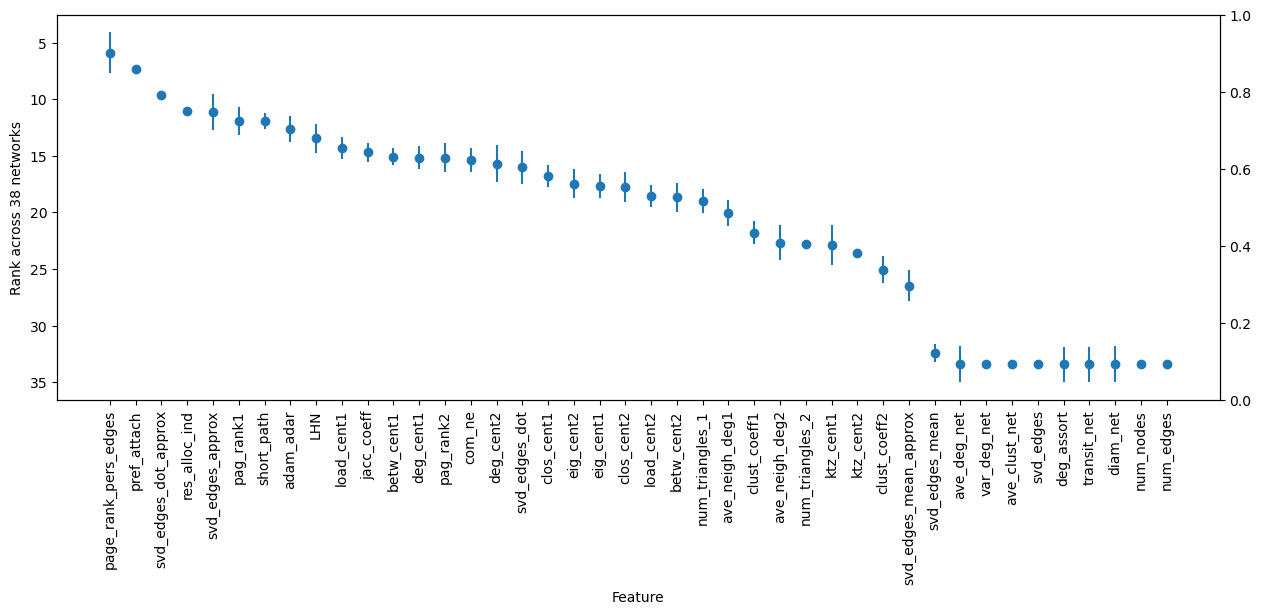

In [87]:
fig, ax1 = plt.subplots(figsize=(15,5))

ax1.errorbar(average_ranking_sorted.keys(),average_ranking_sorted.values(),yerr=list(standard_mean_error_sorted.values()),fmt='o')
_ = ax1.set_xticklabels(average_ranking_sorted.keys(),rotation=90)
ax1.invert_yaxis() 
ax1.set_ylabel("Rank across 38 networks") 
ax1.set_xlabel("Feature") 

ax2 = ax1.twinx()

ax2_time_average = {k:time_average_ranking_sorted[k] for k in average_ranking_sorted.keys()}
ax2_time_sem = {k:time_standard_mean_error_sorted[k] for k in average_ranking_sorted.keys()}
ax2.errorbar(ax2_time_average.keys(),ax2_time_average.values(),yerr=list(ax2_time_sem.values()),fmt='o')
# plt.gca().invert_yaxis() 
ax2.set_ylabel("Rank across 4 networks") 


In [60]:
edge_table = pd.read_csv("../data/derived/networks/preprocessed/airport-rach/edge_table.csv")

src, trg = edge_table["src"].values, edge_table["trg"].values
n_nodes = int(np.maximum(np.max(src), np.max(trg)) + 1)
A_orig = sparse.csr_matrix((np.ones_like(src), (src, trg)), shape=(n_nodes, n_nodes))

model_ho = LinkPredictionDataset(
    testEdgeFraction=0.2,
    negative_edge_sampler="uniform",
)

model_ho.fit(A_orig)
A_ho, holdout_edge_table = model_ho.transform()

100%|██████████| 596/596 [00:00<00:00, 329615.66it/s]


In [61]:
len(holdout_edge_table[holdout_edge_table.isPositiveEdge==1])

596

In [62]:
G = nx.from_scipy_sparse_array(A_orig)

In [63]:
G.number_of_edges()

2980

In [65]:
model_tr = LinkPredictionDataset(
    testEdgeFraction=0.2,
    negative_edge_sampler="uniform",
)
model_tr.fit(A_ho)
A_tr, train_edge_table = model_tr.transform()

100%|██████████| 476/476 [00:00<00:00, 293170.15it/s]


In [67]:
neg_hold_edges = list(zip(holdout_edge_table[holdout_edge_table.isPositiveEdge==0].src,holdout_edge_table[holdout_edge_table.isPositiveEdge==0].trg))
neg_train_edges = list(zip(train_edge_table[train_edge_table.isPositiveEdge==0].src,train_edge_table[train_edge_table.isPositiveEdge==0].trg))

In [68]:
[(i,j) for i,j in neg_train_edges if (i,j) in neg_hold_edges or (j,i) in neg_hold_edges]

[(14, 464),
 (110, 443),
 (8, 40),
 (2, 458),
 (0, 497),
 (72, 172),
 (100, 314),
 (0, 297),
 (36, 198)]

In [72]:
#### extract features #####

# A_orig = A_orig.todense()
# A_ho = A_ho.todense()
# A_tr = A_tr.todense()

# for hyperparmater search (based on the training network (a subgraph of the holdout network))
A_diff = A_ho - A_tr
e_diff = sparse.find(sparse.triu(A_diff, 1))  # true candidates
A_ho_aux = -1 * A_ho + 1
ne_ho = sparse.find(sparse.triu(A_ho_aux, 1))  # false candidates
Nsamples = 10000  # number of samples
edge_t_tr, edge_f_tr = get_true_and_false_edges(Nsamples, e_diff, ne_ho)

# for training model (based on the holdout network (a subgraph of the actual graph))
A_diff = A_orig - A_ho
e_diff = sparse.find(sparse.triu(A_diff, 1))  # true candidates
A_orig_aux = -1 * A_orig + 1
ne_orig = sparse.find(sparse.triu(A_orig_aux, 1))  # false candidates
Nsamples = 10000  # number of samples
edge_t_ho, edge_f_ho = get_true_and_false_edges(Nsamples, e_diff, ne_orig)


In [78]:
len(set(edge_f_tr).intersection(set(edge_f_ho)))

737